In [37]:
from nltk.corpus import stopwords
from nltk import word_tokenize,wordpunct_tokenize,wordnet,FreqDist,PorterStemmer
from nltk.tokenize import TweetTokenizer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import matplotlib.pyplot as plt


### Loading Data

In [38]:
df = pd.read_csv("Covid_19_tweets_train.csv",encoding="latin1")
print(df.sample(20)) 

       UserName  ScreenName                        Location     TweetAt  \
18539     22338       67290                             NaN  23-03-2020   
24800     28599       73551                       The World  27-03-2020   
40173     43972       88924                          mumbai  13-04-2020   
22888     26687       71639                         Phoenix  25-03-2020   
23188     26987       71939                             NaN  25-03-2020   
3210       7009       51961         Wellington, New Zealand  18-03-2020   
32524     36323       81275       McNairy County, Tennessee  07-04-2020   
19022     22821       67773                   Camarillo, CA  24-03-2020   
6622      10421       55373                             NaN  19-03-2020   
25284     29083       74035                Maggie Valley NC  31-03-2020   
23128     26927       71879              Stratford, Ontario  25-03-2020   
23595     27394       72346                        Virginia  26-03-2020   
8825      12624       575

# Data Preprocessing

In [39]:
stop_words = set(stopwords.words("english"))
import string

hashtags = []
def preprocess(text):
    # Lower case
    text = text.lower()
    # remove punct    
    table = str.maketrans('', '', string.punctuation.replace("#",''))
    text = text.translate(table)
    text = text.split()
    hashtags.extend([re.sub("#",'',word) for word in text if "#" in word])
    text = [re.sub("#",'',word) for word in text]
    
    # remove digits and strange symbol 
    text = [re.sub("(\d+|€+)",'',word) for word in text]
    
    # remove urls and empty tweet tags and whitespaces
    text = [word for word in text if re.match(r"^(https)",word) == None and word != "#"]
    text = [word for word in text if word != " "]
    text = " ".join(text)
   
    # remove strange encoding chars
    filters = " ".join(filter(lambda char: char not in string.printable, text))
    if len(filters) > 0:
        text = re.sub(f'[{filters}*]',' ',text)
    
    # tokinaztion
    tokanizer = TweetTokenizer()
    text = tokanizer.tokenize(text)
  
    # remove stopwords and single chars
    text = [t for t in text if t not in stop_words and len(t) > 1]
    lemmatizer = wordnet.WordNetLemmatizer()
    text = [lemmatizer.lemmatize(w) for w in text]
#     hashtags.extend([word for word in text if "#" in word])
#     stemming
#     stemmer = PorterStemmer()
#     text = [stemmer.stem(w) for w in text]
    
    return " ".join(text)

In [40]:
df["CleanedTweet"] = df["OriginalTweet"].apply(lambda x:preprocess(x))

In [41]:
# remove empty cells 
df["CleanedTweet"].replace('',np.nan,inplace=True)
df.dropna(subset=["CleanedTweet"],inplace=True)
nan_value = float("NaN")

df["CleanedTweet"].replace("", nan_value, inplace=True)
df["Sentiment"].replace("", nan_value, inplace=True)

df["CleanedTweet"].dropna(inplace=True)
df["CleanedTweet"].dropna()


df["Sentiment"].dropna(inplace=True)
df["Sentiment"].dropna()

0                   Neutral
1                  Positive
2                  Positive
3                  Positive
4        Extremely Negative
                ...        
41152               Neutral
41153    Extremely Negative
41154              Positive
41155               Neutral
41156              Negative
Name: Sentiment, Length: 41141, dtype: object

In [15]:
df["CleanedTweet"].describe()

count                                     41141
unique                                    40934
top       online shopping way covid restriction
freq                                          7
Name: CleanedTweet, dtype: object

In [7]:
df["OriginalTweet"].describe()

count                                                 41141
unique                                                41141
top       Tips on making requests on   Ask consumer prot...
freq                                                      1
Name: OriginalTweet, dtype: object

# Text Analysis

In [17]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from collections import Counter


In [23]:
# X_train = data["CleanedTweet"][:int(.75 * len(data["CleanedTweet"]))]
# X_test = data["CleanedTweet"][int(.75 * len(data["CleanedTweet"])):]
X = df["CleanedTweet"]
y = df["Sentiment"]

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)



In [10]:
trigram_cv = CountVectorizer(ngram_range=(1,3),min_df=1)
trigram_cv.fit(X)
vectorizer = trigram_cv.transform(X)

count_list = np.array(vectorizer.sum(axis=0).A1)
word_list = np.array(trigram_cv.get_feature_names())

# most common words
freq_distribution = Counter(dict(zip(word_list, count_list)))
print (freq_distribution.most_common(10))


[('covid', 21816), ('coronavirus', 18021), ('price', 8944), ('store', 8164), ('supermarket', 7734), ('food', 7222), ('grocery', 6737), ('people', 5609), ('consumer', 5169), ('grocery store', 5081)]


In [11]:
freq_df = pd.DataFrame(freq_distribution.most_common(30),columns=['word','count'])
freq_df.head()


word  count
0        covid  21816
1  coronavirus  18021
2        price   8944
3        store   8164
4  supermarket   7734

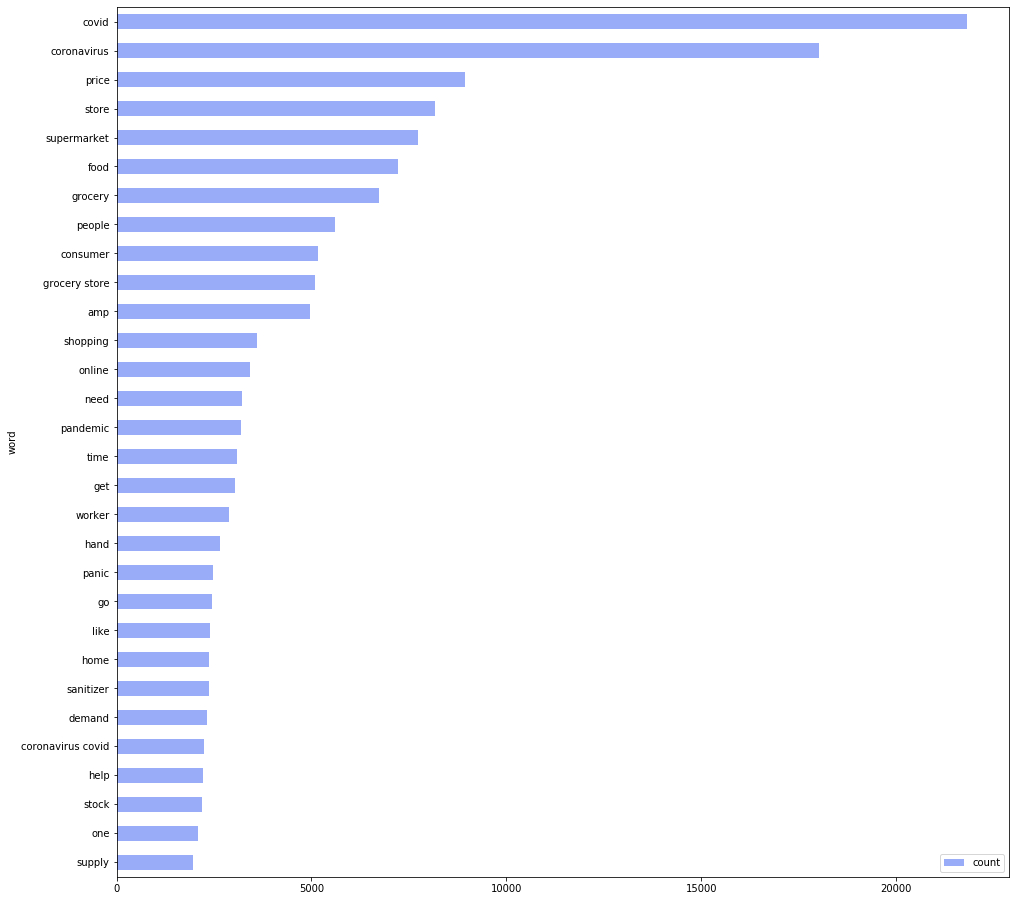

In [12]:
fig, ax = plt.subplots(figsize=(16, 16))
freq_df.sort_values(by='count').plot.barh(
x='word',y='count',ax=ax,color='#98acf8')
plt.show()

# Trending Topics

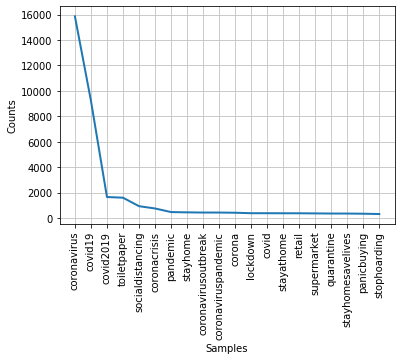

In [13]:
hashtags_freq = FreqDist(hashtags)
hashtags_freq.plot(20)

### remove empty Locations

In [14]:
df.dropna(subset=["Location"],inplace=True)
df["Location"].head(10)

0                        London
1                            UK
2                     Vagabonds
5     ÃT: 36.319708,-82.363649
6          35.926541,-78.753267
7                       Austria
8               Atlanta, GA USA
9              BHAVNAGAR,GUJRAT
10               Makati, Manila
11    Pitt Meadows, BC, Canada 
Name: Location, dtype: object

## plot frequency

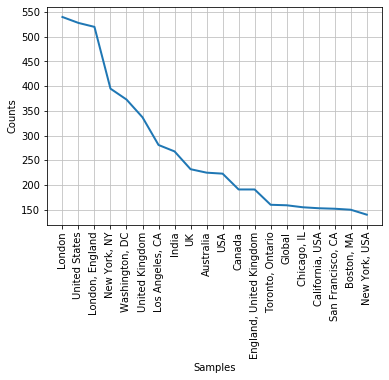

In [15]:
hashtags_freq = FreqDist(df["Location"])
hashtags_freq.plot(20)

In [16]:
pd.set_option('max_rows', None)
pd.set_option("max_colwidth", 80)



# Topic Modeling


In [18]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [21]:
true_k = 3
docs = df["CleanedTweet"]
count_vec = CountVectorizer(stop_words=stop_words)
X = count_vec.fit_transform(docs)
# model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
# y_kmeans = model.fit_predict(X)
tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english',#tokenizer = tokenize_and_stem,
                             max_features = 20000)
tf_idf = tf_idf_vectorizor.fit_transform(docs)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

### trying with K = 3 

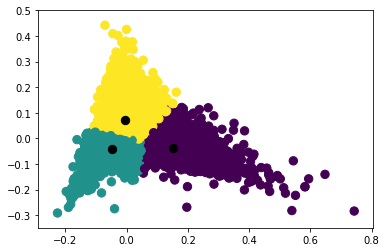

In [19]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
test_e = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=1)
fitted = test_e.fit(Y_sklearn)
predicted_values = test_e.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=70, cmap='viridis')
plt.scatter(test_e.cluster_centers_[:, 0], test_e.cluster_centers_[:, 1], s=70, c='black', label='Centroids' )


# Find best K with Elbow Method

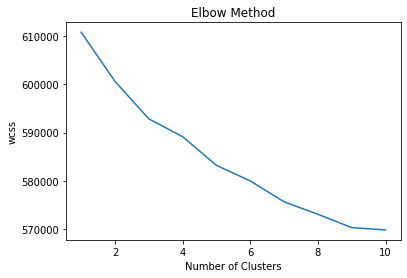

In [20]:



wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')
plt.show()


### Perfect value k = 6

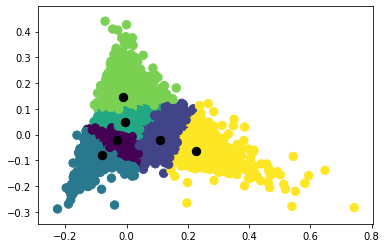

In [21]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters= 6 , init='k-means++', max_iter=100, n_init=1)
fitted = kmeans.fit(Y_sklearn)
predicted_values = kmeans.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=70, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=70, c='black', label='Centroids' )


### data starts mixing with k = 8

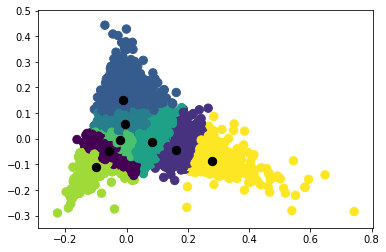

In [22]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters= 8 , init='k-means++', max_iter=100, n_init=1)
fitted = kmeans.fit(Y_sklearn)
predicted_values = kmeans.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=70, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=70, c='black', label='Centroids' )


### k = 10

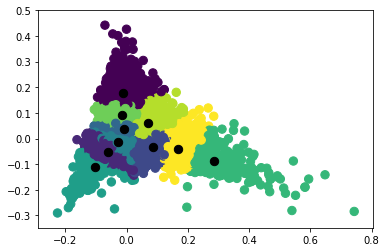

In [23]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters= 10 , init='k-means++', max_iter=100, n_init=1)
fitted = kmeans.fit(Y_sklearn)
predicted_values = kmeans.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=70, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=70, c='black', label='Centroids' )


.

.



# Language Models

In [19]:
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk import word_tokenize, sent_tokenize 
from nltk.util import trigrams

In [23]:
n = 3


tri_tweet_generator = MLE(n)
train_tweets,padded_sent = padded_everygram_pipeline(n,list(docs.apply(word_tokenize)))

In [27]:
tri_tweet_generator.fit(train_tweets,padded_sent)

In [28]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

detokenize = TreebankWordDetokenizer().detokenize
def generate_sent(model, num_words, random_seed=42):
    """
    :param model: An ngram language model from `nltk.lm.model`.
    :param num_words: Max no. of words to generate.
    :param random_seed: Seed value for random.
    """
    content = []
    for token in model.generate(num_words, random_seed=random_seed):
        if token == '<s>':
            continue
        if token == '</s>':
            break
        content.append(token)
    return detokenize(content)

In [32]:
generate_sent(tri_tweet_generator,10,6)

'sale south korea detected day south korea retailer seen unprecedented'

# Sentiment Analysis

In [20]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

### TF-IDF

In [31]:
tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english')
tf_idf = tf_idf_vectorizor.fit_transform(X_train)
tf_idf_norm = normalize(tf_idf)
X_train_tf_idf = tf_idf_norm.toarray()

 

In [35]:
ridgeClassifier = RidgeClassifier()
ridgeClassifier.fit(X_train_tf_idf,y_train)

MemoryError: Unable to allocate 10.1 GiB for an array with shape (30855, 44034) and data type float64

In [ ]:
X_test_tfidf = tf_idf_vectorizor.transform(X_test)
y_test_predicted_labels_tfidf = ridgeClassifier.predict(X_test_tfidf)

print('Tfidf Accuracy: ' + str(accuracy_score(y_test, y_test_predicted_labels_tfidf)))

In [ ]:
clf = MultinomialNB()
clf.fit(X_train_tf_idf, y_train)

In [36]:
X_test_tfidf = tf_idf_vectorizor.transform(X_test)
y_test_predicted_labels_tfidf_NB = clf.predict(X_test_tfidf)
print('Naive Bayes Accuracy TF-IDF: ' + str(accuracy_score(y_test, y_test_predicted_labels_tfidf_NB)))


NameError: name 'clf' is not defined

### BOW


In [186]:
cv = CountVectorizer(ngram_range=(1,4))
X_train_cv = cv.fit_transform(X_train)

ridgeClassifier = RidgeClassifier()
ridgeClassifier.fit(X_train_cv,y_train)

RidgeClassifier()

In [187]:
X_test_cv = cv.transform(X_test)
y_test_predicted_cv = ridgeClassifier.predict(X_test_cv)

print('Count Vectorizer Accuracy: ' + str(accuracy_score(y_test, y_test_predicted_cv)))

Count Vectorizer Accuracy: 0.5359712230215827


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV


In [ ]:


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_test_cv, y_test_cv, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

In [30]:
svc0 = CalibratedClassifierCV(LinearSVC(),cv=10)
svc= OneVsRestClassifier(svc0)

In [35]:
svc.fit(X_train_tf_idf,y_train)

OneVsRestClassifier(estimator=CalibratedClassifierCV(base_estimator=LinearSVC(),
                                                     cv=10))

In [188]:
prediction_svc = svc.predict(X_test_tfidf)
print('Linear SVC TF-IDF Accuracy: ' + str(accuracy_score(y_test, prediction_svc)))

Linear SVC TF-IDF Accuracy: 0.5643593233521291


### Linear SVC with Count Vectorizer

In [189]:
svc.fit(X_train_cv,y_train)
prediction_svc = svc.predict(X_test_cv)
print('Linear SVC Accuracy: ' + str(accuracy_score(y_test, prediction_svc)))

/Users/ammar0ah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ammar0ah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ammar0ah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ammar0ah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/ammar0ah/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: Converge

Linear SVC Accuracy: 0.5880808866420377


In [44]:
df[df["Sentiment"] == "Negative"]

UserName  ScreenName                      Location     TweetAt  \
9          3808       48760              BHAVNAGAR,GUJRAT  16-03-2020   
24         3823       48775              Downstage centre  16-03-2020   
26         3825       48777                Ketchum, Idaho  16-03-2020   
28         3827       48779                  New York, NY  16-03-2020   
30         3829       48781                           NaN  16-03-2020   
...         ...         ...                           ...         ...   
41127     44926       89878                           NaN  14-04-2020   
41131     44930       89882                  Accra, Ghana  14-04-2020   
41147     44946       89898                  Brooklyn, NY  14-04-2020   
41149     44948       89900              Toronto, Ontario  14-04-2020   
41156     44955       89907  i love you so much || he/him  14-04-2020   

                                           OriginalTweet Sentiment  \
9      For corona prevention,we should stop to buy th...  Negative   
24     @10DowningStreet @grantshapps what is being do...  Negative   
26     In preparation for higher demand and a potenti...  Negative   
28     Do you see malicious price increases in NYC? T...  Negative   
30     There Is of in the Country  The more empty she...  Negative   
...                                                  ...       ...   
41127  Today at the grocery store I saw someone getti...  Negative   
41131  In every human affliction there are  gainers a...  Negative   
41147  YÂall really shitting that much more at home?...  Negative   
41149  Still shocked by the number of #Toronto superm...  Negative   
41156  @TartiiCat Well new/used Rift S are going for ...  Negative   

                                            CleanedTweet  
9      corona preventionwe stop buy thing cash use on...  
24     downingstreet grantshapps done ensure food ess...  
26     preparation higher demand potential food short...  
28     see malicious price increase nyc nyc departmen...  
30     country empty shelf people see buying ensues f...  
...                                                  ...  
41127  today grocery store saw someone getting case c...  
41131  every human affliction gainer loser case covid...  
41147  really shitting much home covid coronavirus to...  
41149  still shocked number toronto supermarket emplo...  
41156  tartiicat well newused rift going amazon rn al...  

[9917 rows x 7 columns]

In [139]:
cols = {"Sentiment":df["Sentiment"],"CleanedTweet":df["CleanedTweet"]}
binary_df = pd.DataFrame(cols)
binary_df[binary_df["Sentiment"]=="Extremely Negative"] = "Negative"
binary_df[binary_df["Sentiment"] =="Extremely Positive"] = "Positive"
print(binary_df[binary_df["Sentiment"] == "Negative"].count()+binary_df[binary_df["Sentiment"] == "Positive"].count())


Sentiment       33444
CleanedTweet    33444
dtype: int64


In [140]:
print(binary_df[binary_df["Sentiment"] == "Negative"].count()+binary_df[binary_df["Sentiment"] == "Positive"].count())
neutral = binary_df[binary_df["Sentiment"] == "Neutral"]
print(binary_df[binary_df["Sentiment"] == "Negative"].count()+binary_df[binary_df["Sentiment"] == "Positive"].count())


Sentiment       33444
CleanedTweet    33444
dtype: int64
Sentiment       33444
CleanedTweet    33444
dtype: int64


In [134]:
mask = binary_df.loc[binary_df["Sentiment"] == "Neutral"][:len(neutral)//2 - 1]
mask["Sentiment"] = "Negative"

In [135]:
counter = 0
for i,sentiment in enumerate(binary_df["Sentiment"]):
    if sentiment == "Neutral":
           counter +=1
           binary_df["Sentiment"][i] = "Negative"
    if i == len(neutral) // 2 - 1:
        break

for sentiment in binary_df["Sentiment"][len(neutral)//2:]:
    if sentiment == "Neutral":
        binary_df["Sentiment"][i] = "Positive"
    

In [136]:
print(binary_df[binary_df["Sentiment"] == "Negative"].count(),binary_df[binary_df["Sentiment"] == "Positive"].count())

Sentiment       15789
CleanedTweet    15789
dtype: int64 Sentiment       17782
CleanedTweet    17782
dtype: int64


<ipython-input-136-835df544eb98>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(binary_df[binary_df["Sentiment"] == "Negative"].count(),binary_df[binary_df["Sentiment"] == "Positive"].count())


In [138]:
binary_df.head(100)

Sentiment                                       CleanedTweet
0    Negative                        menyrbie philgahan chrisitv
1    Positive  advice talk neighbour family exchange phone nu...
2    Positive  coronavirus australia woolworth give elderly d...
3    Positive  food stock one empty please dont panic enough ...
4    Negative                                           Negative
..        ...                                                ...
96   Positive  kroger biggest supermarket chain united state ...
97   Positive  kroger instead paid sick leave kroger providin...
98   Positive  followed went shopping day ago pain necessary ...
99   Negative  joncoopertweets took picture today home grocer...
100  Negative                                           Negative

[100 rows x 2 columns]

In [160]:
neutral[:len(neutral)//2 - 1] = "Negative"
neutral[len(neutral)//n:] = "Positive"

<ipython-input-160-77446ee2e9bf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neutral[:len(neutral)//2 - 1] = "Negative"
/Users/ammar0ah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:2945: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer(key, value)
/Users/ammar0ah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:2930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

In [168]:
binary_df.drop(binary_df[binary_df["Sentiment"] == "Neutral"].index,inplace=True)
binary_df.append(neutral)

Sentiment                                       CleanedTweet
1      Positive  advice talk neighbour family exchange phone nu...
2      Positive  coronavirus australia woolworth give elderly d...
3      Positive  food stock one empty please dont panic enough ...
4      Negative                                           Negative
5      Positive  news region first confirmed covid case came su...
...         ...                                                ...
41141  Positive                                           Positive
41143  Positive                                           Positive
41144  Positive                                           Positive
41152  Positive                                           Positive
41155  Positive                                           Positive

[41141 rows x 2 columns]

In [172]:
X_bin = binary_df["CleanedTweet"]
y_bin = binary_df["Sentiment"]
X_train_bin,X_test_bin,y_train_bin,y_test_bin = train_test_split(X_bin,y_bin,random_state=42)

In [179]:
cv_bin = CountVectorizer(ngram_range=(1,4))
cv_train_bin = cv_bin.fit_transform(X_train_bin)
cv_test_bin = cv_bin.transform(X_test_bin)

In [180]:
svc_bin = LinearSVC()
svc_bin.fit(cv_train_bin,y_train_bin)
svc_prediction = svc_bin.predict(cv_test_bin)
print('Linear SVC Accuracy: ' + str(accuracy_score(y_test_bin, svc_prediction)))

Linear SVC Accuracy: 0.8646094964717139


# Deep Learning

In [42]:
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [43]:
import os 
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras
from keras.models import Sequential
from keras.layers import  Embedding,Dense,Flatten,MaxPooling1D,Dropout,LSTM,SpatialDropout1D,Bidirectional,GRU,GlobalMaxPooling1D
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [31]:
X = df["CleanedTweet"]
y = df["Sentiment"]


y[df["Sentiment"]=="Extremely Negative"] = -2
y[df["Sentiment"]=="Negative"] = -1
y[df["Sentiment"]=="Neutral"] = 0
y[df["Sentiment"]=="Positive"] = 1
y[df["Sentiment"]=="Extremely Positive"] = 2

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)


In [32]:
tk = Tokenizer(num_words=5000)
tk.fit_on_texts(X_train)
vocab_size = len(tk.word_index)+1
X_train= tk.texts_to_sequences(X_train)
X_test = tk.texts_to_sequences(X_test)
maxlen=500
X_train = pad_sequences(X_train,padding='post',maxlen=maxlen)
X_test = pad_sequences(X_test,padding='post',maxlen=maxlen)

# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')
# y_train = y_train.astype('float32')
# y_test = y_test.astype('float32')
num_classes = 5
y_train = keras.utils.to_categorical(y_train.astype('float32'), num_classes)
y_test = keras.utils.to_categorical(y_test.astype('float32'), num_classes)


In [63]:
embedding_dim = 200
model = tf.keras.models.Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=embedding_dim,input_length=maxlen))
model.add(MaxPooling1D(pool_size=3))
model.add(LSTM(units=260))
model.add(Flatten())
model.add(Dense(units=embedding_dim//2))
model.add(Dropout(0.2))
model.add(Dense(units=num_classes,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

AttributeError: module 'tensorflow' has no attribute 'get_default_graph'

In [58]:
%%time
history = model.fit(X_train,y_train,epochs=100,shuffle=True,validation_data=(X_test,y_test),batch_size=40)

loss,accuracy = model.evaluate(X_train,y_train)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 30855 samples, validate on 10286 samples
Epoch 1/100
 1760/30855 [>.............................] - ETA: 10:04 - loss: 1.5845 - accuracy: 0.2733

KeyboardInterrupt: 

In [74]:
%%time

UsageError: %%time is a cell magic, but the cell body is empty. Did you mean the line magic %time (single %)?


In [ ]:
plot_history(history)

In [44]:
X = df["CleanedTweet"]
y = df["Sentiment"]

def reclass(x):
  if x == "Extremely Negative":
    return 1
  if x == "Negative":
    return 1
  if x == "Positive":
    return 2
  if x == "Extremely Positive":
    return 2
  return 0

y = y.apply(lambda x:reclass(x))
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)
y.value_counts(normalize= True)


2    0.438638
1    0.374274
0    0.187088
Name: Sentiment, dtype: float64

In [45]:
num_classes = 3
tk = Tokenizer(num_words=5000)
tk.fit_on_texts(X_train)
vocab_size = len(tk.word_index)+1
X_train= tk.texts_to_sequences(X_train)
X_test = tk.texts_to_sequences(X_test)
maxlen=286
X_train = pad_sequences(X_train,padding='post',maxlen=maxlen)
X_test = pad_sequences(X_test,padding='post',maxlen=maxlen)


In [49]:
embedding_dim = 16
model = keras.Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=embedding_dim,input_length=maxlen))
model.add(Bidirectional(GRU(256, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=num_classes,activation='sigmoid'))
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()



ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Kernel execution failure: Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Kernel execution failure: Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (f

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 286, 16)           708208    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 286, 512)          419328    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 195       
Total params: 1,160,563
Trainable params: 1,160,563
Non-trainable params: 0
_________________________________________________________________


ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Kernel execution failure: Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Kernel execution failure: Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (f

In [50]:
history = model.fit(X_train,y_train,epochs=5,shuffle=True,validation_data=(X_test,y_test),batch_size=65,validation_split=0.1)

loss,accuracy = model.evaluate(X_train,y_train)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test)
print("Testing Accuracy:  {:.4f}".format(accuracy))

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

Train on 30855 samples, validate on 10286 samples
Epoch 1/5


ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU erro

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
IOPub message rate exceeded.
The notebook server will temporarily stop sendi

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU erro

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_w

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Kernel execution failure: Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Kernel execution failure: Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)


  195/30855 [..............................] - ETA: 2:26:49 - loss: 0.0000e+00 - acc: 0.0000e+00

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)

ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)
ERROR:plaidml:Ignored (for causing prior/excessive GPU errors) (IOAF code 4)